In [36]:
#1 Importing Libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torchvision
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import joblib
from pathlib import Path
from scipy import stats
import time


In [37]:
#2 Save root directory path.
base_path = Path.cwd().resolve()
print(base_path)

C:\Users\Matth\OneDrive\Desktop\Single_Layer_NN_V1


In [38]:
#3 load Scram codes
data_dir = "2020_LaserNetCSUCombinedData"
os.chdir(f'{base_path}\\{data_dir}\\SCRAM\\Code')
from import_scram import SCRAM
from simulate_scram import SCRAMTarget
from get_data import get_intrp
os.chdir(base_path)

In [39]:
#4 Plotter plots one spectra from an array of points, and simulates one using SCRAM


def plotter(dens, temp, flor, err,dx=0.5e-4, exp_specVH = [],exp_specHR=[],  err2=0, dx2 = 0.5e-4, ploton=False, compare = False,crop=False):
    en_VH = np.linspace(8,9.97,2995) #Spectral range of front side von Hamos spectrometer
    en_HR = np.linspace(8,8.45,2995) #Spectral range of rear side spherical crystal spectrometer
    dens = [dens] #Solid Density copper LOW BoUND: 2.23; HIGH BOUND 18.00
    temp = [temp] #Reasonable temperature of 3.5 keV #LOW BOUND 0.10; HIGH BOUND 6.40
     #Single layer of thickness 500 nm

    #get interpolators for j,k, and fluorescence
    scram = SCRAM(f'{data_dir}/SCRAM/SCRAM.txt')
    j,k,j_f,k_f,fh,fj = scram.get_scram_intrp(dx) #Extracts j, k from SCRAM


    if ploton == True:
        fig, axs = plt.subplots(nrows = 2, ncols = 1)
        fig.set_figwidth(10)
        fig.set_figheight(8)
        fig.tight_layout(pad = 4)
        fig.suptitle('Simulated Spectra with Gaussian Noise')

        axs[0].plot(en_VH,exp_specVH, label = 'Experimental')
        axs[0].set(ylabel = r'Intensity $\frac{mJ}{keV\cdot sr}$')
        axs[0].set(xlabel = 'Photon Energy [keV]')
        if crop == True:
            axs[0].set_xlim(8,8.45)

        axs[1].plot(en_HR,exp_specHR)
        axs[1].set(ylabel = r'Intensity $\frac{mJ}{keV\cdot sr}$')
        axs[1].set(xlabel = 'Photon Energy [keV]');
        axs[1].legend()
        
        if compare == True:
            target1 = SCRAMTarget(dens,temp,j,k,j_f,k_f,fh,fj,en_VH,en_HR,dx) #Generates class object with the specified parameters
    
            #generating test spectra with noise
            #target = SCRAMTarget(dens,temp,j,k,en_VH,en_HR,dx)
            test_VH, test_HR = target1.model(dens,temp,flor,100)

            error = err #controls how noisy the spectra are
            error2 = err2
            noise_VH = np.random.normal(0,error*np.std(test_VH),en_VH.shape)
            noise_HR = np.random.normal(0,error*np.std(test_HR),en_HR.shape)
            
            
            axs[0].plot(en_VH,test_VH+noise_VH, linestyle = '--',label = 'Predicted')
            axs[0].set(ylabel = r'Intensity $\frac{mJ}{keV\cdot sr}$')
            axs[0].set(xlabel = 'Photon Energy [keV]')
            axs[0].legend()
        
            axs[1].plot(en_HR,test_HR+noise_HR,  linestyle = '--')
            axs[1].set(ylabel = r'Intensity $\frac{mJ}{keV\cdot sr}$')
            axs[1].set(xlabel = 'Photon Energy [keV]');
        colors = np.random.rand(3,3)
        axs[0].axvspan(8.01,8.07,alpha=0.3,color=(0.1,0.9,0.1),label =r'$K \alpha$')
        axs[0].axvspan(8.17,8.31,alpha=0.3,color=(.1,0.70,0.400),label =r'$Li-Like$')
        axs[0].axvspan(8.31,8.42,alpha=0.3,color=(0.1,0.60,0.6),label =r'$He \alpha$')
        axs[0].axvspan(8.62,8.72,alpha=0.3,color=(0.3,0.5,0.7),label =r'$Ly \alpha$')
        axs[0].axvspan(8.87,8.92,alpha=0.3,color=(0.4,0.4,0.8),label =r'$K \beta$')
        axs[0].axvspan(9.72,9.9,alpha=0.3,color=(0.7,0.7,0.9),label =r'$He \beta$')
        axs[0].legend()

        axs[1].axvspan(8.01,8.07,alpha=0.3,color=(0.1,0.9,0.1),label =r'$K \alpha$')
        axs[1].axvspan(8.17,8.31,alpha=0.3,color=(.1,0.70,0.400),label =r'$Li-Like$')
        axs[1].axvspan(8.31,8.42,alpha=0.3,color=(0.1,0.60,0.6),label =r'$He \alpha$')
        axs[1].legend()

    
    
    return test_VH+noise_VH

***RUN PREDICTION MODEL***

In [40]:
#5 Define our models and load our state dictionaries
class FeedforwardNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(FeedforwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        #self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        #self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)
        #self.dropout2 = nn.Dropout(p=0.1)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)

        #self.bn3 = nn.BatchNorm1d(hidden_size3)
        self.dropout3 = nn.Dropout(p=0.1)
        self.fc4 = nn.Linear(hidden_size3, output_size)

    def forward(self, x):
        out = self.fc1(x)
        #out = self.bn1(out)
        out = self.relu(out)
        out = self.fc2(out)
        #out = self.bn2(out)
        out = self.leaky_relu(out)
        #out = self.dropout2(out)
        out = self.fc3(out)
        #out = self.bn3(out)
        out = self.relu(out)
        out = self.fc4(out)
        return out


class classifyingNN(nn.Module):
    def __init__(self):
        super(classifyingNN, self).__init__()
        self.fc1 = nn.Linear(5, 10)
        self.fc2 = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x


model100640 = FeedforwardNN(8,128,256,128,2)
model10100 = FeedforwardNN(21,128,256,128,3)

classifier = classifyingNN()

model100640.load_state_dict(torch.load(f'{base_path}\\models\\highNN.pth'))
model10100.load_state_dict(torch.load(f'{base_path}\\models\\lowNN.pth'))
classifier.load_state_dict(torch.load(f'{base_path}\\models\\classifier.pth'))
classipca = joblib.load(f'{base_path}\\classifier\\pca.pkl')


In [41]:
#6 Load our Scalers and PCA transformers
DensityScaler_high = joblib.load(f'{base_path}\\processedhigh\\DensityScaler.pkl')
TempScaler_high = joblib.load(f'{base_path}\\processedhigh\\TempScaler.pkl')
ROIPCA_high = joblib.load(f'{base_path}\\processedhigh\\EIDPCA.pkl')



DensityScaler_low = joblib.load(f'{base_path}\\processedlow\\DensityScaler.pkl')
TempScaler_low = joblib.load(f'{base_path}\\processedlow\\TempScaler.pkl')
HEFScaler_low = joblib.load(f'{base_path}\\processedlow\\HEFScaler.pkl')
ROIPCA_low = joblib.load(f'{base_path}\\processedlow\\EIDPCA.pkl')




In [42]:
#7 Define the baseline subtraction function
def adjust(spec_VH, spec_HR):
      baselineVH,baselineHR = np.zeros((0, 2995)),np.zeros((0, 2995))

      xVH = np.linspace(8,9.97,2995)
      xHR = np.linspace(8,8.45,2995)
      mask = np.zeros(2995, dtype=bool)
      mask[16:107] = True #1
      mask[259:472] = True  #6
      mask[472:639] = True  #6
      mask[943:1095] = True  #6
      mask[1323:1399] = True  #6
      mask[2615:2888] = True  #6
      baselineVH_indices = np.where(~mask)[0]
      baselineVH = np.array(spec_VH[baselineVH_indices])
      baselineVH = np.insert(baselineVH, 16, spec_VH[107:198])
      baselineVH = np.insert(baselineVH, 259, spec_VH[107:168])
      baselineVH = np.insert(baselineVH, 320, spec_VH[107:259])
      baselineVH = np.insert(baselineVH, 472, spec_VH[700:867])
      baselineVH = np.insert(baselineVH, 943, spec_VH[1095:1247])
      baselineVH = np.insert(baselineVH, 1323, spec_VH[1247:1323])
      baselineVH = np.insert(baselineVH, 2615, spec_VH[2449:2615])
      baselineVH = np.append(baselineVH, spec_VH[2721:2828])
      mask = np.zeros(2995, dtype=bool)
      mask[1132:2795] = True
      baselineHR_indices = np.where(~mask)[0]
      baselineHR = np.array(spec_HR[baselineHR_indices])
      baselineHR = np.insert(baselineHR, 1132, spec_HR[0:1132])
      baselineHR = np.insert(baselineHR, 2264, spec_HR[2795:2995])
      baselineHR = np.insert(baselineHR, 2464, spec_HR[2795:2995])
      baselineHR = np.insert(baselineHR, 2664, spec_HR[2795:2926])
      z = np.polyfit(xVH, baselineVH, 1)
      f = np.poly1d(z)
      # plt.plot(xVH,f(xVH),"g",label = "Slope")
      zz = np.polyfit(xHR, baselineHR, 1)
      g = np.poly1d(zz)
      # print(f)
      # print(g)
      
      spec_VH_l = spec_VH + f(xVH)
      spec_HR_l = spec_HR + g(xHR)

      spec_VH = spec_VH - f(xVH)
      spec_HR = spec_HR - g(xHR)

      return spec_VH, spec_HR, spec_VH_l, spec_HR_l

In [43]:
#8 Define all the functions needed for the ensemble model to function as intended
def snv(data):
    mean = np.mean(data, axis=1, keepdims=True)
    std_dev = np.std(data, axis=1, keepdims=True)
    return (data - mean) / std_dev

def recursivemodel(model, energy_intensity_npVH, pcas, densscaler, tempscaler,HEFscaler,switch):
    slicer = pcas.transform(snv(energy_intensity_npVH))
    SNVslice = np.concatenate([slicer[0],[np.array(min(energy_intensity_npVH[0]))],[np.array(max(energy_intensity_npVH[0][0:250]))],[np.array(max(energy_intensity_npVH[0][250:750]))],[np.array(max(energy_intensity_npVH[0][750:1100]))],[np.array(max(energy_intensity_npVH[0][2500:2995]))]]) 
    
    test_tensor = torch.tensor(SNVslice, dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        outputs = model(test_tensor)
        vals = outputs.detach().numpy()
        predicted_labels = pd.DataFrame(vals.reshape(1,-1))
        predicted_labels.iloc[:, 0] = densscaler.inverse_transform(predicted_labels.iloc[:, 0].values.reshape(-1, 1)).flatten()
        predicted_labels.iloc[:, 1] = tempscaler.inverse_transform(predicted_labels.iloc[:, 1].values.reshape(-1, 1)).flatten()
        if switch == False:
            predicted_labels.iloc[:, 2] = HEFscaler.inverse_transform(predicted_labels.iloc[:, 2].values.reshape(-1, 1)).flatten()
            predicted_labels[2] = np.power(10, predicted_labels[2])
        vals = predicted_labels.to_numpy()[0]
        if switch == True:
            vals = np.append(vals,1e-3)
        
    return vals

    
def modelensemble(energy_intensity_npVH): 
    outputs_ = True
    classy = classipca.transform(snv(energy_intensity_npVH))
    outputs_ = classifier(torch.tensor(classy, dtype=torch.float32)).detach().numpy().flatten()[0]>0.5
    
    if outputs_ == True:
        print('High temp')
        vals = recursivemodel(model100640,energy_intensity_npVH, ROIPCA_high,DensityScaler_high,TempScaler_high,1,outputs_)
        #vals = recursivemodel(model10100_2,low_scalers,energy_intensity_npVH, low_PCA, DensityScaler_low,TempScaler_low,HEFScaler_low,False)
    if outputs_ == False:
        print('Low temp')
        vals = recursivemodel(model10100,energy_intensity_npVH, ROIPCA_low, DensityScaler_low,TempScaler_low,HEFScaler_low,outputs_)
    return vals
   
    
    
    

In [65]:
#9 Load in an experimental spectra.

#import data from Dec 17,2020 for 0.5um Cu with best focus

#cu @ 0.5um are: 20-26 12/17; 35-42 12/15

shotlist = [21]#[18,19,20,21]
exp_path = f'{base_path}\\{data_dir}\\Data\\20201217\\CombinedData' #absolute path to shots
spec_VH, spec_HR, err_VH, err_HR = get_intrp(exp_path, shotlist) #intrp for data
en_VH = np.linspace(8, 9.97, 2995) #Energy axis FRONT
en_HR = np.linspace(8, 8.45, 2995) #Energy axis REAR

#creating arrays from the data
spec_VH = spec_VH(en_VH)
spec_HR = spec_HR(en_HR)
err_VH = err_VH(en_VH)
err_HR = err_HR(en_HR)

Current Shots: 

Number: 22	Target: 0.5um Cu		Focus: 100um Defocus

2000


High temp
[8.55647564e+00 3.02871609e+00 1.00000000e-03]
5e-05


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


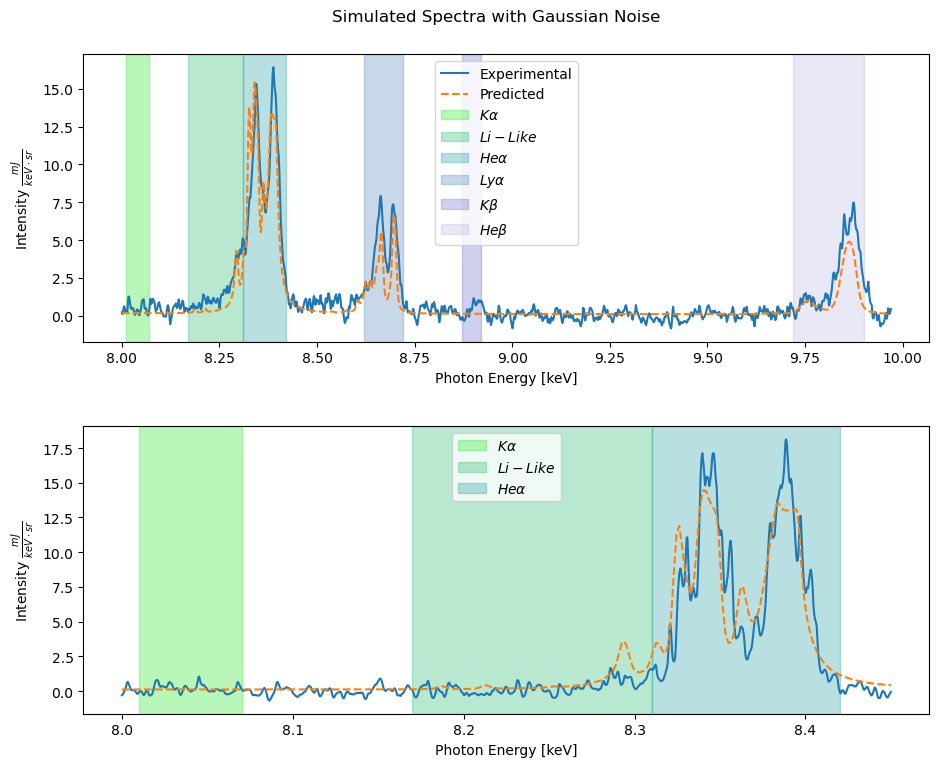

In [66]:
#10 Evaluate the spectra with no baseline subtraction

outputs = modelensemble([spec_VH])
print(outputs)
pk = plotter(outputs[0],outputs[1],outputs[2], 0, exp_specHR=spec_HR, exp_specVH=spec_VH,ploton=True,compare = True,crop=False)

In [67]:
#11 Run the baseline subtraction funtion on the experimental spectra
spec_VH, spec_HR, spec_VH_l, spec_HR_l = adjust(spec_VH,spec_HR)

High temp
[8.46080589e+00 3.02652431e+00 1.00000000e-03]
5e-05


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


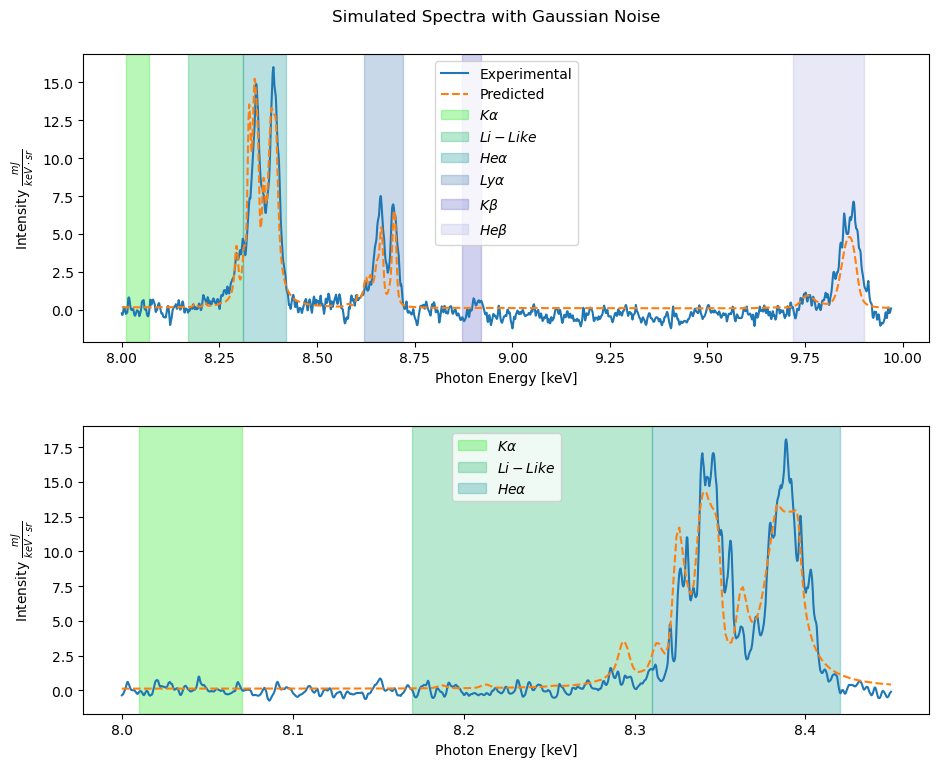

In [68]:
#12 Evaluate the spectra with baseline subtraction

outputs = modelensemble([spec_VH])
print(outputs)
pk = plotter(outputs[0],outputs[1],outputs[2], 0, exp_specHR=spec_HR, exp_specVH=spec_VH,ploton=True,compare = True,crop=False)

High temp
[5.56320095e+00 2.23254395e+00 1.00000000e-03]
5e-05


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


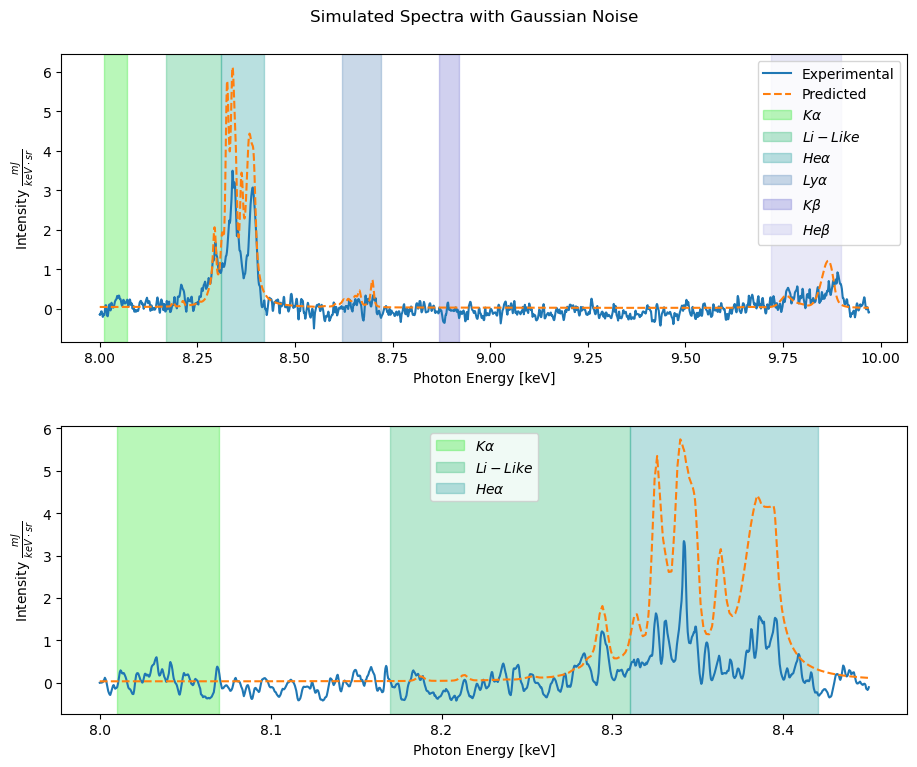

In [64]:
#12 Evaluate the spectra with the baseline added again
outputs = modelensemble([spec_VH_l])
print(outputs)
pk = plotter(outputs[0],outputs[1],outputs[2], 0, exp_specHR=spec_HR, exp_specVH=spec_VH,ploton=True,compare = True,crop=False)